In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os
from importlib import reload

In [126]:
import dataset_utils
from glob import glob

In [127]:
reload(dataset_utils)

<module 'dataset_utils' from '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/dataset_utils.py'>

In [128]:
INIT_TIMESTAMP = "12_10_2024_pointnet_padded_no_bg_rm_augmented"

In [129]:
bg_noise_dir = '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/data/03_09_2024_katie_pc_bg_noise/unique_bg_points.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [130]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        # filtered_data.append(point)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            filtered_data.append([0,0,0,0,0])
            points_removed.append(point)
    return filtered_data

In [131]:
def no_background_subtraction(current_frame_data):
    filtered_data = []
    for point in current_frame_data:
        filtered_data.append(point)
    return filtered_data

In [132]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = no_background_subtraction(arr)
                    # bg_rm_arr = background_subtraction(background_data, arr)
                    train_points_sample.append(bg_rm_arr)
                train_points_sample = np.array(train_points_sample).reshape(-1,5).astype(np.float16)
                train_points.append(train_points_sample)
                train_labels.append(i)
               
        
        for f in test_files:
            test_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    bg_rm_arr = no_background_subtraction(arr)
                    # bg_rm_arr = background_subtraction(background_data, arr)
                    test_points_sample.append(bg_rm_arr)
                test_points_sample = np.array(test_points_sample).reshape(-1,5).astype(np.float16)
                test_points.append(test_points_sample)
                test_labels.append(i)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [133]:
DATA_DIR = "cluster_data/padded"
NUM_POINTS = 300
NUM_FRAMES = 3
NUM_CLASSES = 4
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: walking
processing class: picking_up
processing class: jumping
processing class: sitting
train_points shape: (1393, 300, 5)
test_points shape: (349, 300, 5)
train_labels shape: (1393,)
test_labels shape: (349,)


In [134]:
print(train_points)

[[[ 1.8066e-02  1.4307e+00  7.9199e-01 -6.2598e-01  3.8800e+02]
  [ 1.9531e-03  1.4268e+00  8.4570e-01 -6.2598e-01  3.6800e+02]
  [ 1.9531e-03  1.4082e+00  8.2617e-01 -6.2598e-01  3.1900e+02]
  ...
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]]

 [[-1.2910e+00  1.1504e+00  1.0039e+00  3.7573e-01  3.0300e+02]
  [-1.1816e+00  1.0312e+00  8.6621e-01  2.5049e-01  3.3900e+02]
  [-1.2656e+00  1.1729e+00  1.1455e+00  3.7573e-01  3.6000e+02]
  ...
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
  [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]]

 [[-4.7266e-01  1.6396e+00  9.5801e-01  2.5049e-01  2.8200e+02]
  [-5.3809e-01  1.6523e+00  9.6094e-01  2.5049e-01  2.6400e+02]
  [-4.6582e-01  1.7412e+00  1.0244e+00  2.5049e-01  2.8100e+02]
  ...
  [ 0.0000e+00  0.

In [135]:
print(test_points)

[[[ 9.521e-02  3.000e+00  1.557e+00  7.515e-01  3.170e+02]
  [ 9.082e-02  2.887e+00  1.245e+00  7.515e-01  3.170e+02]
  [ 2.002e-02  2.811e+00  1.481e+00  8.765e-01  3.160e+02]
  ...
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]]

 [[-1.465e-02  1.071e+00  1.383e+00 -7.515e-01  3.460e+02]
  [ 7.275e-02  1.088e+00  1.172e+00 -7.515e-01  3.000e+02]
  [-1.045e-01  9.702e-01  1.340e+00 -8.765e-01  3.350e+02]
  ...
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]]

 [[-4.229e-01  3.854e+00  1.524e+00 -3.757e-01  2.850e+02]
  [-4.512e-01  3.578e+00  8.525e-01 -3.757e-01  1.250e+02]
  [-5.088e-01  3.975e+00  1.422e+00 -2.505e-01  2.660e+02]
  ...
  [ 5.088e-01  2.104e+00 -2.383e-01  6.260e-01  1.920e+02]
  [ 0.000e+00  0.000e+00  0.000e+0

In [136]:
# train_points = train_points[:, :, :3]
# test_points = test_points[:, :, :3]
print(CLASS_MAP)

{0: 'walking', 1: 'picking_up', 2: 'jumping', 3: 'sitting'}


In [137]:
from tensorflow import data as tf_data
import keras
import PointNET



In [138]:
keras.utils.set_random_seed(seed=42)
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(buffer_size=len(train_points))
test_dataset = test_dataset.shuffle(buffer_size=len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).map(PointNET.augment)
train_dataset = train_dataset.batch(BATCH_SIZE)
# train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [139]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn

In [140]:
inputs = keras.Input(shape=(NUM_POINTS, 5))

x = tnet(inputs, 5)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 300, 32)   │        192 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 32)   │        128 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_102      │ (None, 300, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 300, 64)   │      2,112 │ activation_102[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 64)   │        256 │ conv1d_67[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_103      │ (None, 300, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 300, 512)  │     33,280 │ activation_103[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 512)  │      2,048 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_104      │ (None, 300, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_104[0… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_54[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_105      │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 128)       │     32,896 │ activation_105[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_55[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_106      │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 25)        │      3,225 │ activation_106[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 5, 5)      │          0 │ dense_56[0][0]  

 Total params: 750,397 (2.86 MB)

 Trainable params: 744,317 (2.84 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [141]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [142]:

checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [143]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [144]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [145]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Add the checkpoint callback here
)

Epoch 1/20


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 50.6646 - sparse_categorical_accuracy: 0.3437
Epoch 1: val_loss improved from inf to 37.44291, saving model to model/checkpoints/12_10_2024_pointnet_padded_no_bg_rm_augmented/best.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - loss: 50.4363 - sparse_categorical_accuracy: 0.3443 - val_loss: 37.4429 - val_sparse_categorical_accuracy: 0.3441
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 37.8065 - sparse_categorical_accuracy: 0.4082
Epoch 2: val_loss did not improve from 37.44291
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 37.7970 - sparse_categorical_accuracy: 0.4087 - val_loss: 39.4155 - val_sparse_categorical_accuracy: 0.4910
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 37.4673 - sparse_categorical_accuracy: 0.5482
Epoch 3: val_loss improved from 37.44291 to 36.41672, saving model to model/checkpoints/12_10_2024_pointnet_padded_no_bg_rm_augmented/best.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms

In [146]:
from matplotlib import pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
[[[ 5.088e-01  1.827e+00  5.645e-01 -6.260e-01  3.000e+02]
  [ 5.527e-01  1.833e+00  7.617e-01 -8.765e-01  2.710e+02]
  [ 5.293e-01  1.801e+00  4.805e-01 -8.765e-01  2.790e+02]
  ...
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]]

 [[-4.807e-01  1.274e+00  1.140e+00  2.505e-01  3.430e+02]
  [-4.277e-01  1.082e+00  9.619e-01  2.505e-01  3.790e+02]
  [-4.277e-01  1.239e+00  1.116e+00  2.505e-01  3.490e+02]
  ...
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]]

 [[ 2.959e-01  2.027e+00  4.219e-01  1.252e-01  1.240e+02]
  [ 2.959e-01  2.002e+00  3.936e-01  0.000e+00  1.420e+02]
  [ 3.701e-01  2.033e+00  5.488e-01 -1.252e-01  1.150e+02]
  ...
  [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e

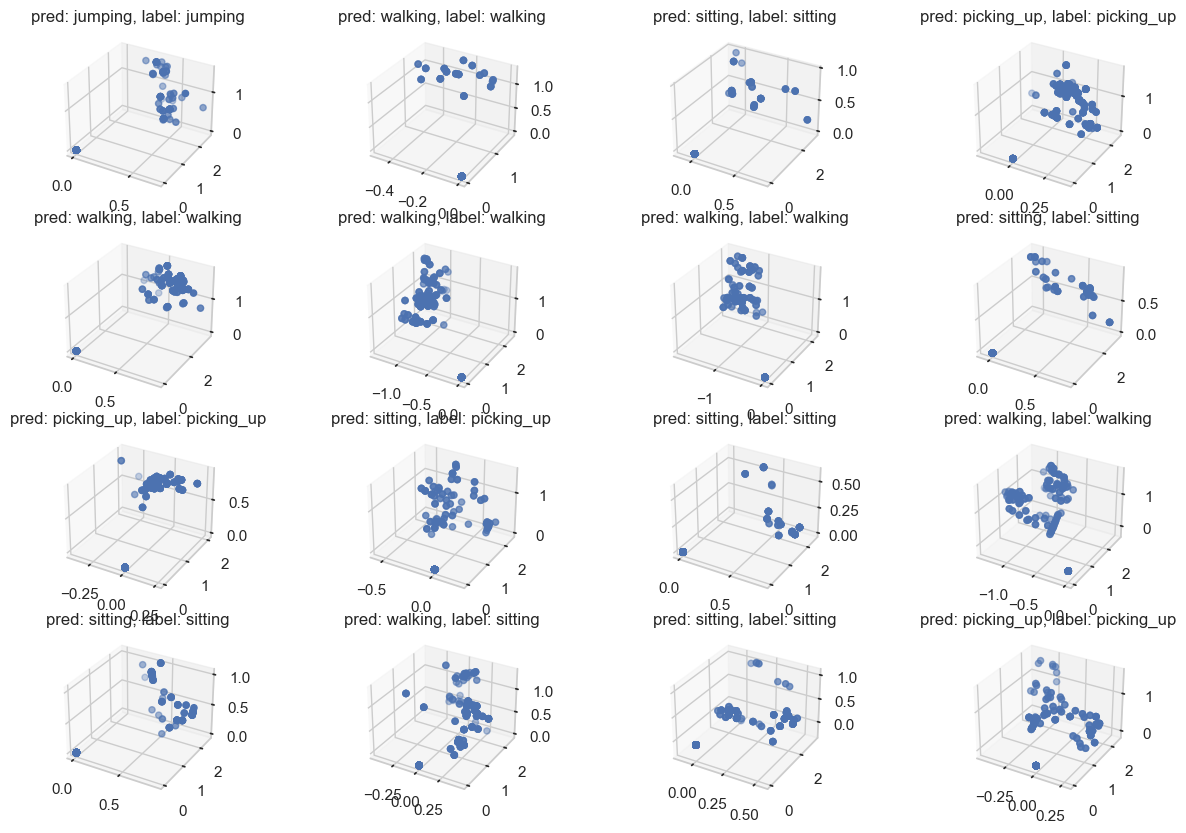

In [147]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [148]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [149]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.22%


              precision    recall  f1-score     support
0              0.794643  0.741667  0.767241  120.000000
1              0.769231  0.750000  0.759494   80.000000
2              0.806818  0.887500  0.845238   80.000000
3              0.746479  0.768116  0.757143   69.000000
accuracy       0.782235  0.782235  0.782235    0.782235
macro avg      0.779293  0.786821  0.782279  349.000000
weighted avg   0.782086  0.782235  0.781348  349.000000


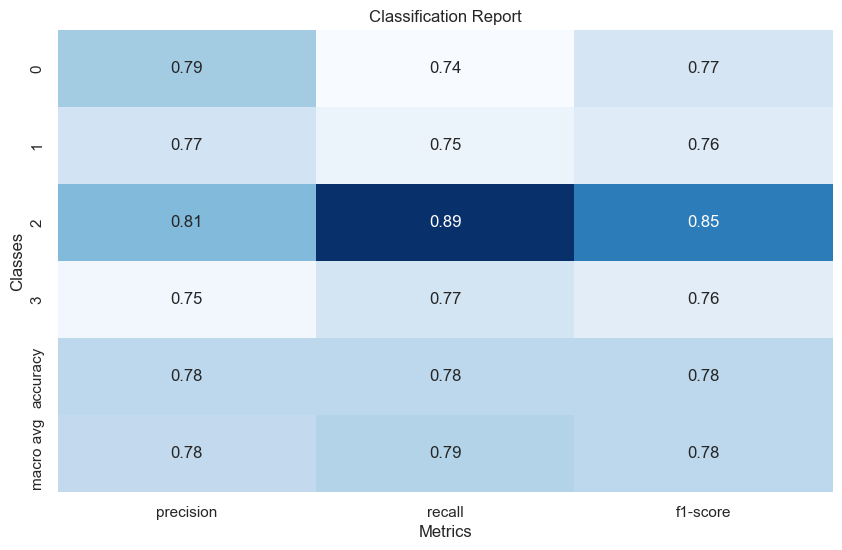

In [150]:
import pandas as pd
from sklearn.metrics import classification_report

# Assume `true_labels` contains the true class labels for your test set
# And `predictions` contains the predicted class labels

# Generate the classification report
report = classification_report(test_labels, predictions, output_dict=True)

# Convert the report to a DataFrame for better formatting
report_df = pd.DataFrame(report).transpose()

# Print the DataFrame
print(report_df)

# If you want to format the DataFrame nicely in Jupyter Notebook
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a heatmap to visualize the report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()


In [153]:
from sklearn.metrics import classification_report

# Assuming predictions and test_labels are numpy arrays with class labels
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

# Calculate Accuracy
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate Precision, Recall, and F1-Score
report = classification_report(test_labels, predictions, target_names=['class_0', 'class_1', 'class_2', 'class_3'])
print(report)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Accuracy: 78.22%
              precision    recall  f1-score   support

     class_0       0.79      0.74      0.77       120
     class_1       0.77      0.75      0.76        80
     class_2       0.81      0.89      0.85        80
     class_3       0.75      0.77      0.76        69

    accuracy                           0.78       349
   macro avg       0.78      0.79      0.78       349
weighted avg       0.78      0.78      0.78       349



In [151]:
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


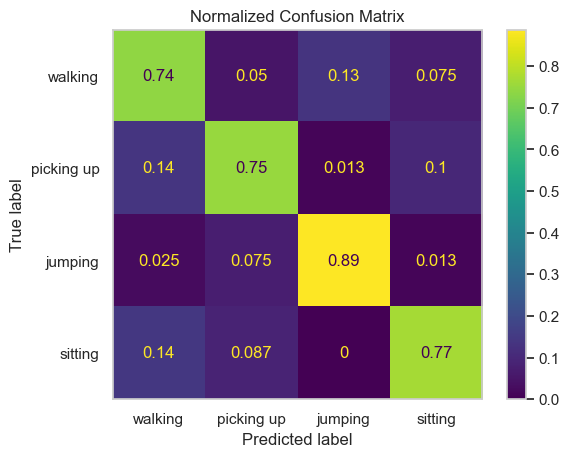

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Normalize the confusion matrix by row (true label)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix
class_names = ['walking', 'picking up', 'jumping', 'sitting']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm_normalized, display_labels=class_names)

# Display the plot without grid lines
disp.plot()
plt.title("Normalized Confusion Matrix")
plt.gca().grid(False)  # Remove grid lines
plt.show()


In [37]:
#reload model
reload_model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
reload_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [38]:
reload_model.load_weights('model/checkpoints/2_09_2024/iter-20.weights.h5')

/Users/katiezhou/mambaforge/envs/py38/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 150 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
